# Q learning : application

Dans cette séance on testera l'algorithme de Q learning avec un environnement de simulation d'OpenAI gymnasium (anciennement gym)

https://gymnasium.farama.org/

### Quelques installations

Selon ce qui est déjà installé dans votre environnement de travail, vous aurez besoin de quelques librairies.

In [ ]:
!pip install ipywidgets numpy ffmpeg ffmpeg-python swig
!pip install gym[box2d]==0.25.1
# si toujours des problèmes avec ffmpeg:
#!conda install ffmpeg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.6 MB/s eta 0:00:00
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=9ae8bbe17696e9cbac1eded6edbe37bc663fe43a9cb1a55c47c52bc78da5d318
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.2/732.2 kB 10.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.25.1-py3-none-any.whl size=849024 sha256=36aa597a8f34f051cb7782a

In [ ]:
%pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.8 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.animation as animation
import matplotlib.cm as cm

In [ ]:
# pour lire des videos locales facilement
from base64 import b64encode
from IPython.display import HTML


def play_video(v_path,width=400):
      mp4 = open(v_path,'rb').read()
      data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
      return HTML("""
          <video width=%d controls>
          <source src="%s" type="video/mp4">
          </video>
          """ % (width,data_url))

## Découverte des environnements d'OpenAI Gym

Gym définit des mondes dans lesquels on peut avoir un agent qui agit sur l'environnement, et avoir l'observation de certaines variables de cet environnement.

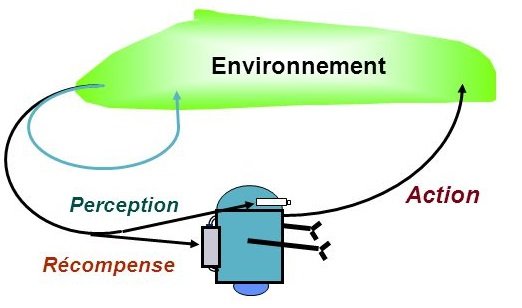




On utilisera plusieurs environnements, mais voyons déjà celui ci:
un module lunaire essaie d'atterrir en douceur sur un emplacement fixé

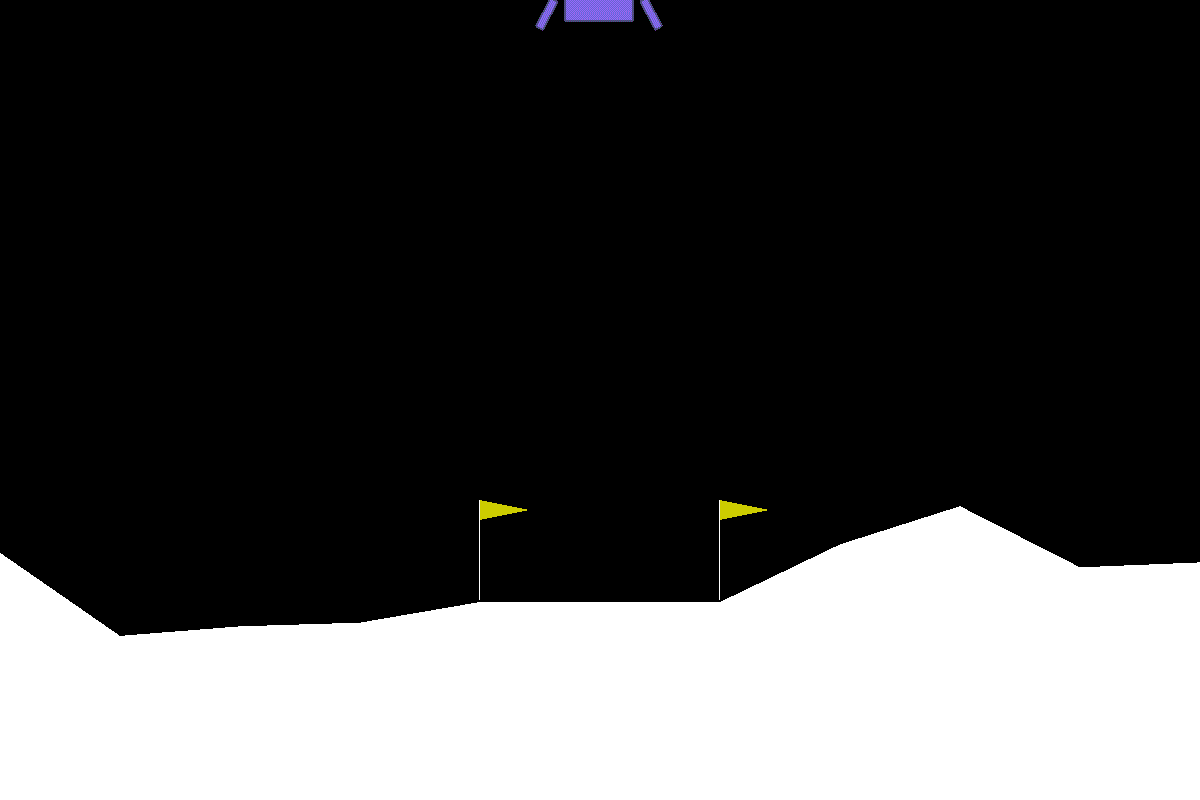

In [ ]:
# On charge un environnement. l'option render_mode détermine le rendu visuel des simulations.
# ici on sauvera des images
env = gym.make("LunarLander-v3",continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
# on l'initialise sur un état de départ. -> renvoie une "observation" : un état de l'environnement
env.reset()

(array([-0.00534801,  1.4023591 , -0.5417185 , -0.38050267,  0.00620386,
         0.12270727,  0.        ,  0.        ], dtype=float32),
 {})

Chaque environnement comprend un espace d'actions possibles par l'agent, qui est ici un module d'atterrissage lunaire doté de deux moteurs latéraux, et un moteur principal. L'agent peut aussi ne rien faire.

In [ ]:
# Espace des actions
# Nop, fire left engine, main engine, right engine
print(env.action_space)
# on peut échantilloner une action au hasard
print(env.action_space.sample())

Discrete(4)
0


In [ ]:
print(env.action_space.n)

4


L'environnement définit un certain nombre de variables observables.

In [ ]:
# Espace des observations
# 0,1: Position X, Y
# 2,3: vitesse vx, vx
# 4: angle / vertical
# 5: angle vitesse rotation
# 6,7: pas utilisés

obs = env.reset()
print(obs[0].shape)
obs

(8,)


(array([ 1.0077476e-03,  1.4134107e+00,  1.0205357e-01,  1.1069067e-01,
        -1.1608765e-03, -2.3116646e-02,  0.0000000e+00,  0.0000000e+00],
       dtype=float32),
 {})

A chaque action faite par un agent, l'environnement informe sur le nouvel état, donne une récompense (prédéfinie et fixé pour chaque monde), et renvoie aussi une condition qui précise si la simulation est finie (crash ou atterrissage réussi).

In [ ]:
#faire une action, constater l'état suivant, reward etc
observation, reward, done, truncated, info = env.step(1)
print(reward, done, truncated, info, end="\n")

2.480752680633118 False False {}


## I) Ecrire une fonction de simulation qui fait une séquence d'action au hasard

et enregistre les récompenses et la trajectoire de chaque variable observée.


In [ ]:
# version à compléter
def random_sequence(env,nb):
        observation = env.reset()
        # sauve les observations pour faire des stats
        trajectory = []
        # somme des renforcements
        total = 0
        for t in range(nb):
            # choisir une action
            action = env.action_space.sample()
            observation, reward, done, truncated, info = env.step(action)
            total += reward
            trajectory.append(observation)

            if done:
              observation = env.reset()
              final = reward

        env.close()
        return final, total, trajectory

In [ ]:
# voilà comment créer l'environnement pour avoir accès à une simulation d'épisode et les stats d'un épisode
# un nouvel épisode est créé à chaque env.reset(), et stocké.

env = gym.make("LunarLander-v3",continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5,
               render_mode="rgb_array")

env = RecordVideo(env, video_folder="lunar-lander", name_prefix="eval",
                  episode_trigger=lambda x: True)

env = RecordEpisodeStatistics(env, buffer_length=200)
final, total, trajectory = random_sequence(env,200)
print("final reward = ",final)
print("total reward = ", total)
print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

final reward =  -100
total reward =  -475.70419204079303
Episode time taken: deque([0.40334, 0.466709], maxlen=200)
Episode total rewards: deque([-108.18104523642415, -315.35185291206994], maxlen=200)
Episode lengths: deque([69, 62], maxlen=200)


In [ ]:
# une video a du être créée pour chaque épisode (ici un seul)
play_video("lunar-lander/eval-episode-0.mp4",width=600)

In [ ]:
env.close()

In [ ]:
trajectory = np.array(trajectory)

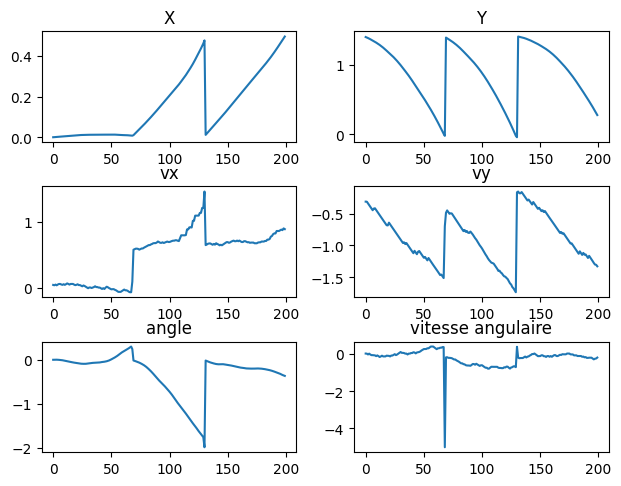

In [ ]:
# On peut observer l'évolution des variables au cours de la simulation

# Espace des observations
variables = {0:"X",1:"Y",   # Position X, Y
             2:"vx",3:"vy", # vecteur vitesse vx, vy
             4:"angle",     # / vertical
             5:"vitesse angulaire",
            }
%matplotlib inline
fig, axs = plt.subplots(3,2)
fig.tight_layout()
fig.figsize = (20,20)
for i in range(6):
    axs[i//2,i%2].set_title(variables[i])
    axs[i//2,i%2].plot(trajectory[:,i])


## Q learning dans l'environnement Frozen Lake

Nous allons d'abord expérimenter le Q-learning dans un environnement un peu plus simple avec peu d'états: le "frozen lake" où nous allons apprendre à un agent à rejoindre son but en évitant de tomber dans l'eau :

<div><img src="attachment:frozen_lake_gym.gif" width="200"></div>

N'hésitez pas à aller voir la doc:

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Dans une 2e partie nous  verrons aussi que l'environnement peut être traitre avec des actions non-déterministes (sur la glace on ne contrôle pas toujours ses mouvements !)

In [ ]:
# il y a deux grilles prédéfinies de tailles 4x4 ou 8x8.
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False,render_mode="rgb_array")
env.reset()

(0, {'prob': 1})

on peut customiser aussi en utilisant les codes :

S=start, G=goal, H=hole, F=frozen

In [ ]:
desc=["SFFF",
      "HFFH",
      "HHFH", # variante plus dure : mettre HHFH
      "FFFF",
      "GFFF"]

desc_8x8 = [
    "SFFHFFFF",
    "FHFHHFFF",
    "FFFFFFHF",
    "FFFFHHHF",
    "FHFFFFHF",
    "FHFFFFFF",
    "FFHFHFFH",
    "FFHHFFFG"
]

env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False,render_mode="rgb_array")
env.reset()
env2 = gym.make('FrozenLake-v1', desc=desc_8x8, is_slippery=False,render_mode="rgb_array")
env2.reset()
# si aucune description ou map_name n'est donné un environnement est généré au hasard
# en forçant l'existence d'un chemin

(0, {'prob': 1})

on peut observer un environnement en l'affichant.

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
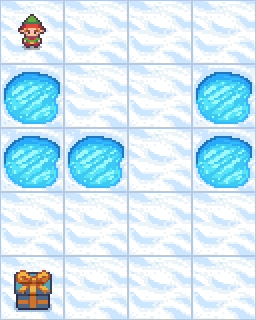

In [ ]:
image = env.render()
image

### Explorer l'environnement

 - vérifiez le nombre d'actions, essayer de trouver quel code correspond à quelle action en observant le résultat d'une action sur un environnement donné
 - regarder ce qui définit un état donné
 - essayer de trouver les récompenses des actions selon le type de case d'arrivée en regardant la table définie par l'environement env.P

In [ ]:
action_name = {0:"left",
               1:"down",
               2:"right",
               3:"up"
              }

In [ ]:
# recompenses doc :
#    Reach goal: +1
#    Reach hole: 0
#    Reach frozen: 0

###  Q-learning

Vous allez maintenant implémenter un apprentissage par Q-learning :

   - en définissant une table Q avec numpy (plus facile pour la suite): quelles sont les options pour initialiser cette table ?
   - en implémentant un apprentissage $\epsilon$-greedy
   - tester avec un entrainement assez rapide pour voir que cela semble fonctionner
   - tester l'apprentissage avec la grille 4x4 "facile" puis la version "dure".
   - afficher la courbe d'évolution de la récompense totale d'un épisode, et la politique optimale définie par votre table finale (= affichez la meilleure action pour chaque état)
   - changez les valeurs des rewards pour accélérer l'entrainement

Voici un schéma de boucle d'entrainement, qui doit dépendre d'un certain nombre de paramètres.

In [ ]:
from tqdm import tqdm



def init_Qtable(nb_states,nb_actions):
    Qtable = np.zeros((nb_states,nb_actions))
    return Qtable

Qtable = init_Qtable(env.observation_space.n,env.action_space.n)

def train(n_episodes, env, max_steps, Qtable, gamma=0.9, epsilon=0.3, alpha=0.2):
    all_rewards = []
    for episode in tqdm(range(n_episodes)):
            # Reset the environment pour avoir l'état de départ s
            state_dict = env.reset()
            state = state_dict[0]
            total_reward = 0
            for step in range(max_steps):
                # choisir une action a avec la stratégie epsilon greedy
                if np.random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(Qtable[state, :])

                # faire l'action et récupérer le résultat
                new_state, reward, done, truncated, info = env.step(action)

                # mise à jour de Q(s,a)
                if not(done): # mise à jour différente si on arrive dans l'état final
                    Qtable[state,action] = Qtable[state,action] + alpha*(reward + gamma*np.max(Qtable[new_state,:]) - Qtable[state,action])

                else:
                    Qtable[state,action] = Qtable[state,action] + alpha*(reward - Qtable[state,action])
                # mise à jour de l'état
                state = new_state
                total_reward += reward

            all_rewards.append(total_reward)

    return Qtable, all_rewards

In [ ]:
train(1000,env,100,Qtable)

100%|██████████| 1000/1000 [00:02<00:00, 338.71it/s]


(array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  

In [ ]:
# Faites d'abord des essais sans cette partie, puis revenez ensuite compléter:
# en fait on voit qu'avec les rewards de départ l'apprentissage est très lent
# -> on change les rewards pour guider plus

# dans cet environnement, la table des rewards est stocké dans un dictionnaire
#     env.env.env.env.P
# observez cette table avec la fonction suivante :

def display_table(P):
    for s in P:
        print(s,P[s])

# on voit quel état est terminal et avec quelle récompense
# -> changer la reward pour les trous
# -> changer aussi reward de faire un pas


def change_rewards(P):
    # Parcourir tous les états
    for state in P:
        # Parcourir toutes les actions possibles
        for action in P[state]:
            # P[state][action] est une liste de tuples (probabilité, prochain état, récompense, terminal)
            for idx, (prob, next_state, reward, done) in enumerate(P[state][action]):
                # Si c'est un trou (done=True et reward=0 par défaut dans FrozenLake)
                if done and reward == 0:
                    # Modifier la récompense pour les trous
                    P[state][action][idx] = (prob, next_state, -1, done)  # Par exemple, -1 pour pénaliser
                # Si c'est un simple pas non terminal
                elif not done:
                    # Modifier la récompense pour faire un pas
                    P[state][action][idx] = (prob, next_state, -0.1, done)  # Par exemple, -0.1 pour légèrement pénaliser

    return P

# Changer les récompenses dans l'environnement
env.env.env.env.P = change_rewards(env.env.env.env.P)
env2.env.env.env.P = change_rewards(env2.env.env.env.P)

# Afficher la table des transitions après modification
display_table(env.env.env.env.P)

0 {0: [(1.0, 0, -0.1, False)], 1: [(1.0, 4, -1, True)], 2: [(1.0, 1, -0.1, False)], 3: [(1.0, 0, -0.1, False)]}
1 {0: [(1.0, 0, -0.1, False)], 1: [(1.0, 5, -0.1, False)], 2: [(1.0, 2, -0.1, False)], 3: [(1.0, 1, -0.1, False)]}
2 {0: [(1.0, 1, -0.1, False)], 1: [(1.0, 6, -0.1, False)], 2: [(1.0, 3, -0.1, False)], 3: [(1.0, 2, -0.1, False)]}
3 {0: [(1.0, 2, -0.1, False)], 1: [(1.0, 7, -1, True)], 2: [(1.0, 3, -0.1, False)], 3: [(1.0, 3, -0.1, False)]}
4 {0: [(1.0, 4, -1, True)], 1: [(1.0, 4, -1, True)], 2: [(1.0, 4, -1, True)], 3: [(1.0, 4, -1, True)]}
5 {0: [(1.0, 4, -1, True)], 1: [(1.0, 9, -1, True)], 2: [(1.0, 6, -0.1, False)], 3: [(1.0, 1, -0.1, False)]}
6 {0: [(1.0, 5, -0.1, False)], 1: [(1.0, 10, -0.1, False)], 2: [(1.0, 7, -1, True)], 3: [(1.0, 2, -0.1, False)]}
7 {0: [(1.0, 7, -1, True)], 1: [(1.0, 7, -1, True)], 2: [(1.0, 7, -1, True)], 3: [(1.0, 7, -1, True)]}
8 {0: [(1.0, 8, -1, True)], 1: [(1.0, 8, -1, True)], 2: [(1.0, 8, -1, True)], 3: [(1.0, 8, -1, True)]}
9 {0: [(1.0, 9,

**Explications :**

La fonction change_rewards ajuste les récompenses pour rendre l'apprentissage plus efficace : en pénalisant davantage les trous (en les attribuant une récompense de -1) et en pénalisant légèrement les déplacements non terminaux (-0.1), ce qui guide l'agent à éviter les pièges et à privilégier les actions qui mènent à des états bénéfiques.



In [ ]:
frozen_Q = init_Qtable(env.observation_space.n,env.action_space.n)
frozen_Q2 = init_Qtable(env2.observation_space.n,env.action_space.n)
frozen_Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
frozen_Q, rewards = train(1000,env,100,frozen_Q)

100%|██████████| 1000/1000 [00:03<00:00, 329.58it/s]


In [ ]:
frozen_Q2, rewards2 = train(1000,env2,100,frozen_Q2)

100%|██████████| 1000/1000 [00:02<00:00, 366.52it/s]


In [ ]:
frozen_Q

array([[-0.13906559, -1.        , -0.0434062 , -0.13906558],
       [-0.1390656 ,  0.062882  ,  0.06288199, -0.0434062 ],
       [-0.05590883,  0.18098   , -0.08436334,  0.03235181],
       [ 0.05342329, -0.67232   , -0.28440247, -0.25575567],
       [-1.        , -1.        , -1.        , -1.        ],
       [-1.        , -0.99999996,  0.18098   , -0.04340632],
       [ 0.06288164,  0.3122    , -1.        ,  0.06287425],
       [-1.        , -1.        , -1.        , -1.        ],
       [-0.99077663, -0.98847078, -0.98847078, -0.98847078],
       [-1.        , -1.        , -1.        , -1.        ],
       [-0.99999902,  0.458     , -0.9999777 ,  0.18097543],
       [-1.        , -1.        , -1.        , -1.        ],
       [-0.02      ,  0.5904    ,  0.12197361, -0.2       ],
       [ 0.122112  ,  0.79999987,  0.33117349, -0.89262582],
       [ 0.61948388,  0.62      ,  0.31167647,  0.31218121],
       [ 0.45795267,  0.23955468,  0.21663193, -0.7902848 ],
       [-1.        , -1.

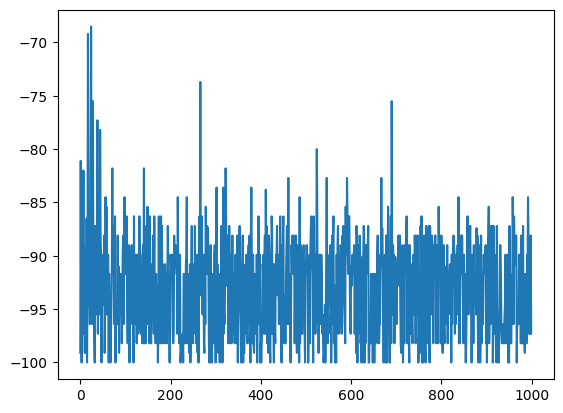

In [ ]:
plt.plot(rewards)

In [ ]:
print("--politique optimale--")
# Créer un dictionnaire des actions possibles (0: left, 1: down, 2: right, 3: up)
action_name = {0: "left", 1: "down", 2: "right", 3: "up"}

# Afficher les actions optimales pour chaque état de la grille
for i, row in enumerate(desc):
    row_str = ""
    for j, cell in enumerate(row):
        # Trouver l'état correspondant à la position (i, j)
        state = i * len(row) + j

        # Trouver l'action optimale (celle avec la plus grande valeur dans la table Q)
        action_optimal = np.argmax(frozen_Q[state, :])

        # Ajouter l'action optimale à la ligne
        row_str += action_name[action_optimal][0].upper() + " "  # Prenons la première lettre de l'action
    print(row_str)
print("---grille----")
print("\n".join(desc))

--politique optimale--
R D D L 
L R D L 
D L D L 
D D D L 
L L L L 
---grille----
SFFF
HFFH
HHFH
FFFF
GFFF


**Explications :**

Dans cette politique, l'agent est guidé pour éviter les trous (les cases "H") et se dirige vers l'objectif (la case "G"). Par exemple, dans la première ligne, l'agent doit se déplacer vers la droite (R), puis vers le bas (D) et ainsi de suite, selon les directions optimales déterminées par l'algorithme d'apprentissage. Cette politique minimise les risques en choisissant des actions qui maximisent la récompense et évitent les pièges, jusqu'à atteindre l'objectif final.

Ensuite :
   - Faire une fonction qui évalue les performances de l'agent à partir de la table de Q
   - Esayer d'améliorer l'apprentissage en jouant sur les différents paramètres
   - Une option possible pour l'exploration est de faire un epsilon variable, qui diminue au fur et à mesure qu'on connait mieux l'environnement
   - Ecrire une fonction qui simule un épisode avec la table Q finale puis visualisez avec play_video
   - Appliquez le tout aussi à l'environnement "slippery" (glissant) où les actions sont non-déterministes
   - Essayez avec un environnement plus grand 8x8 et/ou une grille définie par vous-même.

In [ ]:
def evaluate_agent(env, max_steps, n_episodes, Qtable):
    # doit renvoyer la moyenne et l'écart-type du total des récompenses par épisode
    s0 = env.reset()
    all_rew = []
    for episode in tqdm(range(n_episodes)):
            state_dict = env.reset()
            state = state_dict[0]
            total_reward = 0

            for step in range(max_steps):
                # Choisir la meilleure action à partir de la table Q
                action = np.argmax(Qtable[state, :])
                new_state, reward, done, truncated, info = env.step(action)
                total_reward += reward
                state = new_state
                if done:
                    break

            all_rew.append(total_reward)

    # Calculer la moyenne et l'écart-type des récompenses totales
    stats = np.array(all_rew)
    mean_reward = np.mean(stats)
    std_reward = np.std(stats)
    return mean_reward, std_reward

m,std = evaluate_agent(env,100,100,frozen_Q)
print(f"Performance de l'agent : Moyenne = {m}, Écart-type = {std}")

100%|██████████| 100/100 [00:00<00:00, 5838.64it/s]

Performance de l'agent : Moyenne = 0.3, Écart-type = 5.551115123125783e-17


**Explications :**

*   Moyenne = 0.3 indique que l'agent a, en moyenne, obtenu une récompense de 0.3 par épisode. Cela peut signifier que l'agent a réussi à atteindre l'objectif dans certains épisodes, mais a également fait face à des pénalités ou des erreurs dans d'autres épisodes.
Une moyenne de 0.3 indique probablement que l'agent n'a pas toujours atteint l'objectif, mais qu'il a tout de même appris une stratégie relativement efficace.
*   Un écart-type aussi faible (près de zéro) indique que les récompenses obtenues par l'agent sont extrêmement cohérentes d'un épisode à l'autre. Cela signifie que l'agent a adopté une stratégie stable, produisant des résultats pratiquement identiques dans tous les épisodes.





In [ ]:
import os
import shutil

In [ ]:
def simulation(env, Qtable, max_steps=100, video_folder="./videos", video_filename="episode_video.mp4"):

    # Ajouter un wrapper pour enregistrer la vidéo
    env = RecordVideo(env, video_folder=video_folder, disable_logger=True)

    # Réinitialiser l'environnement
    state_dict = env.reset()
    state = state_dict[0]

    for step in range(max_steps):
        # Choisir la meilleure action à partir de la table Q
        action = np.argmax(Qtable[state, :])

        # Effectuer l'action
        new_state, reward, done, truncated, info = env.step(action)
        state = new_state

        if done:
            break

    env.close()

     # Renommer la vidéo enregistrée après l'exécution
    video_path = f"{video_folder}/rl-video-episode-0.mp4"  # Gym génère ce nom par défaut
    new_video_path = f"{video_folder}/{video_filename}"    # Le chemin avec le nom spécifié

    # Renommer la vidéo
    if os.path.exists(video_path):
        shutil.move(video_path, new_video_path)

    # Retourne le chemin du fichier vidéo
    return f"{video_folder}/{video_filename}"

In [ ]:
# Créer la simulation et enregistrer la vidéo
video_path = simulation(env, frozen_Q, max_steps=100, video_folder="./videos", video_filename="video_eps_fixe.mp4")

# Lire la vidéo
play_video(video_path)

In [ ]:
print("--politique optimale--")
# Afficher les actions optimales pour chaque état de la grille
for i, row in enumerate(desc_8x8):
    row_str = ""
    for j, cell in enumerate(row):
        # Trouver l'état correspondant à la position (i, j)
        state = i * len(row) + j

        # Trouver l'action optimale (celle avec la plus grande valeur dans la table Q)
        action_optimal = np.argmax(frozen_Q2[state, :])

        # Ajouter l'action optimale à la ligne
        row_str += action_name[action_optimal][0].upper() + " "  # Prenons la première lettre de l'action
    print(row_str)
print("---grille----")
print("\n".join(desc_8x8))

--politique optimale--
D R D L R L R U 
D L D L L U U R 
R R D D L U L R 
R R R D L L D D 
U L R R R D L D 
U L R R R D D L 
D L L U L R D L 
R U L U R R R L 
---grille----
SFFHFFFF
FHFHHFFF
FFFFFFHF
FFFFHHHF
FHFFFFHF
FHFFFFFF
FFHFHFFH
FFHHFFFG


In [ ]:
# grille 8x8
video_path2 = simulation(env2, frozen_Q2, max_steps=100, video_folder="./videos", video_filename="video_eps_fixe_8x8.mp4")

play_video(video_path2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Avec un epsilon variable :


In [46]:
def train_variable_epsilon_linear(n_episodes, env, max_steps, Qtable, gamma=0.9, epsilon_start=1.0, epsilon_end=0.1, alpha=0.1, n=2):
    epsilon_decay = (epsilon_start - epsilon_end) / (n_episodes / n)  # Diminution plus lente
    epsilon = epsilon_start
    all_rewards = []

    for episode in tqdm(range(n_episodes)):
        # Réinitialiser l'environnement
        state_dict = env.reset()
        state = state_dict[0]
        total_reward = 0

        for step in range(max_steps):
            # Choisir une action (epsilon greedy avec epsilon variable)
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Qtable[state, :])

            # Faire l'action et récupérer le résultat
            new_state, reward, done, truncated, info = env.step(action)

            # Mise à jour de Q(s,a)
            if not done:
                Qtable[state, action] += alpha * (reward + gamma * np.max(Qtable[new_state, :]) - Qtable[state, action])
            else:
                Qtable[state, action] += alpha * (reward - Qtable[state, action])

            # Mise à jour de l'état et des récompenses
            state = new_state
            total_reward += reward

            if done:
                break

        all_rewards.append(total_reward)

        # Mise à jour de epsilon avec une décroissance linéaire
        epsilon = max(epsilon_end, epsilon - epsilon_decay)  # Assurer que epsilon ne tombe pas sous epsilon_end

    return Qtable, all_rewards



**Explications :**

Une stratégie pour améliorer l'apprentissage par renforcement consiste à ajuster la diminution du taux d'exploration (epsilon) de manière progressive et contrôlée. Cela permet à l'agent de continuer à explorer l'environnement suffisamment longtemps pour découvrir des stratégies plus efficaces avant de se concentrer sur l'exploitation de la politique apprise.

En pratique, si epsilon diminue trop rapidement, l'agent risque de tomber dans ce qu'on appelle l'exploitation prématurée. Cela signifie qu'il peut se retrouver à privilégier une politique sous-optimale, simplement parce qu'il n'a pas eu assez d'opportunités d'explorer d'autres actions et d'observer leurs impacts dans différents états.

J'ai opté pour une diminution plus lente et progressive d'epsilon, en ajustant son déclin à travers un mécanisme de décroissance linéaire. Cela garantit que même dans les derniers épisodes, l'agent maintient un certain degré d'exploration.


In [47]:
# Initialisation de la table Q
frozen_Q2 = init_Qtable(env.observation_space.n, env.action_space.n)

# Entraînement avec epsilon variable
frozen_Q2, all_rewards2 = train_variable_epsilon_linear(1000, env, 100, frozen_Q2, alpha=0.2, n=1)

# Calcul des statistiques d'évaluation
m2, std2 = evaluate_agent(env, 100, 100, frozen_Q2)

100%|██████████| 100/100 [00:00<00:00, 6444.94it/s]


In [48]:
# Affichage de la politique optimale
print("-- Politique optimale --")

for i, row in enumerate(desc):
    row_str = ""
    for j, cell in enumerate(row):
        state = i * len(row) + j
        action_optimal = np.argmax(frozen_Q2[state, :])
        row_str += action_name[action_optimal][0].upper() + " "
    print(row_str)

print("\n--- Grille ---")
print("\n".join(desc))

-- Politique optimale --
R R D L 
L R D L 
L L D L 
D D L L 
L L L L 

--- Grille ---
SFFF
HFFH
HHFH
FFFF
GFFF


In [ ]:
video_path2 = simulation(env, frozen_Q2, max_steps=100, video_folder="./videos", video_filename="video_eps_variable.mp4")
play_video(video_path2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### Initialiser l'environnement avec une grille de taille 8x8 et l'option slippery

In [ ]:
# Créer l'environnement 8x8 avec des actions glissantes (slippery)
env_slippery = gym.make("FrozenLake-v1", desc=desc_8x8, is_slippery=True, render_mode="rgb_array")
env_slippery.reset()

(0, {'prob': 1})

In [ ]:
def change_rewards_slippery(P):
    # Parcourir tous les états
    for state in P:
        # Parcourir toutes les actions possibles
        for action in P[state]:
            # P[state][action] est une liste de tuples (probabilité, prochain état, récompense, terminal)
            for idx, (prob, next_state, reward, done) in enumerate(P[state][action]):
                # Si c'est un trou (done=True et reward=0 par défaut dans FrozenLake)
                if done and reward == 0:  # On suppose que reward=0 est un trou
                    # Modifier la récompense pour les trous
                    P[state][action][idx] = (prob, next_state, -1, done)  # -1 pour pénaliser
                elif done and reward == 1:  # Si l'état est objectif
                    # Modifier la récompense pour atteindre l'objectif
                    P[state][action][idx] = (prob, next_state, 1, done)  # Récompense 1 pour l'objectif
                # Si c'est un simple pas non terminal
                elif not done:
                    # Modifier la récompense pour chaque pas effectué
                    P[state][action][idx] = (prob, next_state, -0.1, done)  # Légère pénalité pour chaque déplacement

    return P

# Changer les récompenses dans l'environnement
env_slippery.env.env.env.P = change_rewards_slippery(env_slippery.env.env.env.P)

In [49]:
# Initialisation de la Q-table
frozen_Q3 = init_Qtable(env_slippery.observation_space.n, env_slippery.action_space.n)

# Entraînement avec epsilon variable
frozen_Q3, all_rewards3 = train_variable_epsilon_linear(50000, env_slippery, 500, frozen_Q3, n=4)

100%|██████████| 50000/50000 [00:51<00:00, 976.68it/s]


In [50]:
# Évaluation de l'agent
m3, std3 = evaluate_agent(env_slippery, 100, 100, frozen_Q3)
print(f"Performance de l'agent : Moyenne = {m3}, Écart-type = {std3}")

100%|██████████| 100/100 [00:00<00:00, 1384.66it/s]

Performance de l'agent : Moyenne = -5.7869999999999955, Écart-type = 2.780527108301582




**Explications :**

Analyse des performances dans un environnement non-déterministe :

- Moyenne = -5.787
Dans un environnement non-déterministe, chaque action peut mener à des résultats différents selon une probabilité prédéfinie. Une moyenne négative aussi basse indique que l'agent subit souvent des pénalités au cours de ses épisodes, probablement dues à des transitions défavorables imprévisibles. Cela peut signifier que l'agent n'a pas encore trouvé une stratégie robuste pour s'adapter à la variabilité de l'environnement.

- Écart-type = 2.781
L'écart-type relativement élevé reflète la nature non-déterministe de l'environnement. Cette variabilité est amplifiée par le fait que certaines actions mènent à des résultats très différents en fonction des probabilités associées. Cela peut également indiquer que l'agent ne réagit pas encore de manière cohérente face à cette incertitude, alternant entre des épisodes où il parvient à mieux gérer l'aléatoire et d'autres où il échoue.


In [ ]:
# Affichage de la politique optimale
print("-- Politique optimale --")

for i, row in enumerate(desc_8x8):
    row_str = ""
    for j, cell in enumerate(row):
        state = i * len(row) + j
        action_optimal = np.argmax(frozen_Q3[state, :])
        row_str += action_name[action_optimal][0].upper() + " "
    print(row_str)

print("\n--- Grille ---")
print("\n".join(desc_8x8))

-- Politique optimale --
L U L L R R R R 
L L L L L R U R 
D D D D U L L R 
U U R L L L L R 
L L R D D L L R 
L L U U U D D U 
L D L R L R D L 
L L L L D D U L 

--- Grille ---
SFFHFFFF
FHFHHFFF
FFFFFFHF
FFFFHHHF
FHFFFFHF
FHFFFFFF
FFHFHFFH
FFHHFFFG


In [ ]:
# Simulation et enregistrement de la vidéo avec le nom de fichier personnalisé
video_path3 = simulation(env_slippery, frozen_Q3, max_steps=100, video_folder="./videos", video_filename="video_eps_fixe_8x8.mp4")

# Lire la vidéo
play_video(video_path3)

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



**Explications :**

Approches adoptées :


1.   Augmentation du nombre d’épisodes (50 000) et du nombre de pas (500) :
J’ai augmenté ces paramètres pour permettre à l’agent de disposer de plus de temps d’interaction avec l’environnement. En théorie, cela devait lui donner la possibilité d’explorer davantage et de mieux comprendre les dynamiques complexes de l’environnement, notamment les transitions incertaines. Cependant, bien que cette approche ait pu légèrement améliorer l’apprentissage, les résultats sont restés limités, suggérant que d’autres facteurs freinent la convergence vers une politique optimale.

2.   Expérimentations sur les paramètres alpha et gamma :

- Alpha (taux d’apprentissage) : J’ai testé des valeurs plus faibles pour alpha, car un apprentissage plus lent peut être bénéfique dans un environnement non-déterministe. Cela permet à l’agent de lisser l’impact des variations imprévisibles sur la mise à jour des Q-values, réduisant ainsi les biais liés aux transitions aléatoires individuelles.

- Gamma (facteur de discount) : J’ai également ajusté gamma pour encourager l’agent à prendre davantage en compte les récompenses futures. Cela est particulièrement pertinent dans un environnement non-déterministe, où les actions immédiates peuvent ne pas refléter leur impact réel à long terme. Bien que cela ait permis à l’agent de mieux envisager des trajectoires globalement avantageuses, il semble que les incertitudes de court terme aient toujours un impact négatif significatif sur les performances.

